## Introduction
##This notebook creates a step-by-step guide to load the EEG data and apply the MSSTNet model for a 2-class classification task.
1. Import all the necessary libraries.
2. Import the data
3. The separate files for preprocessing is available in the preprocessing folder.
4. The output of the preprocessing is stored as X.pickle, and the labels as y.pickle
5. Since MSSTNet uses multiple inputs from different freqency bands of the EEG signal, the data (X) must be prepared for each band accordingly.
4. Z-score normalization is applied on the data.  
5. The model is defined
6. Model training  




## Packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import pickle
import tensorflow
from tensorflow import keras
import numpy as np
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, cohen_kappa_score, roc_auc_score, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, LSTM, Dense, Flatten, BatchNormalization, MaxPooling2D, Activation, GlobalAvgPool2D, Dropout
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, LSTM, TimeDistributed, BatchNormalization, Activation, GlobalAvgPool2D
from tensorflow.keras.models import Model



##Load Preprocessed Data

In [2]:
X_alpha = pickle.load(open("/content/drive/MyDrive/MW/final_data_bandwise/alpha_band_pickle/X.pickle","rb"))
X_beta = pickle.load(open("/content/drive/MyDrive/MW/final_data_bandwise/beta_band_pickle/X.pickle","rb"))
Y = pickle.load(open("/content/drive/MyDrive/MW/final_data_bandwise/alpha_band_pickle/y.pickle","rb"))
print("done")

done


##Add Time Distributed axis

In [3]:
print(np.array(X_alpha).shape)
X_alpha = np.array(X_alpha).reshape(977, 4, 64, 2048, 1)
X_beta = np.array(X_beta).reshape(977, 4, 64, 2048, 1)
print(X_alpha.shape)

(977, 64, 8192)
(977, 4, 64, 2048, 1)


## Normalization

In [ ]:
mean = np.mean(X_alpha,axis=0)
std_dev = np.std(X_alpha,axis=0)
X_alpha = X_alpha - mean
X = X_alpha/std_dev

mean = np.mean(X_beta,axis=0)
std_dev = np.std(X_beta,axis=0)
X_beta = X_beta - mean
X_beta = X_beta/std_dev

## Define Model

In [5]:
def MSSTNet():
  # Define the input shapes for the two inputs
  input_shape = (4, 64, 2048, 1)

  # Input layers
  input1 = Input(shape=input_shape)
  input2 = Input(shape=input_shape)

  # CNN layers for both inputs (shared architecture)
  def cnn_branch(input_tensor):
    x = TimeDistributed(Conv2D(filters=10, kernel_size=(1, 10), activation='relu'))(input_tensor)
    x = TimeDistributed(Conv2D(filters=10, kernel_size=(64, 1), activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(1, 2), strides=2))(x)
    x = Activation("relu")(x)
    x = TimeDistributed(Conv2D(filters=10, kernel_size=(1, 10), activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(1, 2), strides=2))(x)
    x = Activation("relu")(x)
    x = TimeDistributed(Conv2D(filters=10, kernel_size=(1, 10), activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(1, 4), strides=4))(x)
    x = Activation("relu")(x)
    x = TimeDistributed(Conv2D(filters=10, kernel_size=(1, 10), activation='relu'))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(1, 3), strides=3))(x)
    x = Activation("relu")(x)
    x = TimeDistributed(GlobalAvgPool2D())(x)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(80)(x)
    return x

  # Apply the CNN branch to both inputs
  x1 = cnn_branch(input1)
  x2 = cnn_branch(input2)

  # Concatenate the outputs of the two CNN branches
  merged = concatenate([x1, x2])

  # LSTM layer
  #merged = LSTM(80)(merged)

  # Dense layers for output
  merged = Dense(200, activation='relu')(merged)
  merged = Dense(100, activation='relu')(merged)
  merged = Dense(1, activation='sigmoid')(merged)

  # Create the model
  model = Model(inputs=[input1, input2], outputs=merged)

  # Compile the model
  optimizer = keras.optimizers.Adam(lr=0.01)
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

  return model

# Create the model
model = MSSTNet()

# Print the model summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 4, 64, 2048, 1) │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 4, 64, 2048, 1) │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 4, 64, 2039,    │            110 │ input_layer[0][0]      │
│ (TimeDistributed)         │ 10)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_15       │ (None, 4, 64, 2039,    │            110 │ input_layer_1[0][0]    │
│ (TimeDistributed)         │ 10)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 4, 1, 2039, 10) │          6,410 │ time_distributed[0][0] │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_16       │ (None, 4, 1, 2039, 10) │          6,410 │ time_distributed_15[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, 4, 1, 2039, 10) │             40 │ time_distributed_1[0]… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_17       │ (None, 4, 1, 2039, 10) │             40 │ time_distributed_16[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_3        │ (None, 4, 1, 1019, 10) │              0 │ time_distributed_2[0]… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_18       │ (None, 4, 1, 1019, 10) │              0 │ time_distributed_17[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 4, 1, 1019, 10) │              0 │ time_distributed_3[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activation) │ (None, 4, 1, 1019, 10) │              0 │ time_distributed_18[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_4        │ (None, 4, 1, 1010, 10) │          1,010 │ activation[0][0]       │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_19       │ (None, 4, 1, 1010, 10) │          1,010 │ activation_4[0][0]     │
│ (TimeDistributed)         │                        │                │                        │
├──────────────────────

 Total params: 130,061 (508.05 KB)

 Trainable params: 129,901 (507.43 KB)

 Non-trainable params: 160 (640.00 B)

## Model Training

In [ ]:

# the number of folds
n_splits = 10

# Initialize StratifiedKFold
skf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Lists to store the evaluation metrics for each fold
accuracy_scores = []
loss_scores = []

# Iterate through the folds
for fold, (train_index, test_index) in enumerate(skf.split(X_alpha, Y)):
  print('fold:',fold)

  # Split the data into training and validation sets for this fold
  X1_train, X1_test = X_alpha[train_index], X_alpha[test_index]
  X2_train, X2_test = X_beta[train_index], X_beta[test_index]

  Y_train, Y_test = np.array(Y)[train_index], np.array(Y)[test_index]

  # Create a new model for each fold
  model = MSSTNet()

  # Define early stopping to prevent overfitting
  early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

  # Train the model
  history = model.fit([X1_train,X2_train], Y_train, epochs=150, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

  # # Evaluate the model on the test set

  Y_pred = model.predict((X1_test,X2_test))
  Y_pred_binary = (Y_pred > 0.5).astype(int)
  accuracy = accuracy_score(Y_test, Y_pred_binary)
  sensitivity = recall_score(Y_test, Y_pred_binary)
  specificity = recall_score(Y_test, Y_pred_binary, pos_label=0)
  precision = precision_score(Y_test, Y_pred_binary)
  f1 = f1_score(Y_test, Y_pred_binary)
  kappa = cohen_kappa_score(Y_test, Y_pred_binary)
  auc = roc_auc_score(Y_test, Y_pred)
  print(f"Accuracy: {accuracy:.4f}")
  print(f"Sensitivity: {sensitivity:.4f}")
  print(f"Specificity: {specificity:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"F1-Score: {f1:.4f}")
  print(f"Cohen's Kappa: {kappa:.4f}")
  print(f"AUC: {auc:.4f}")


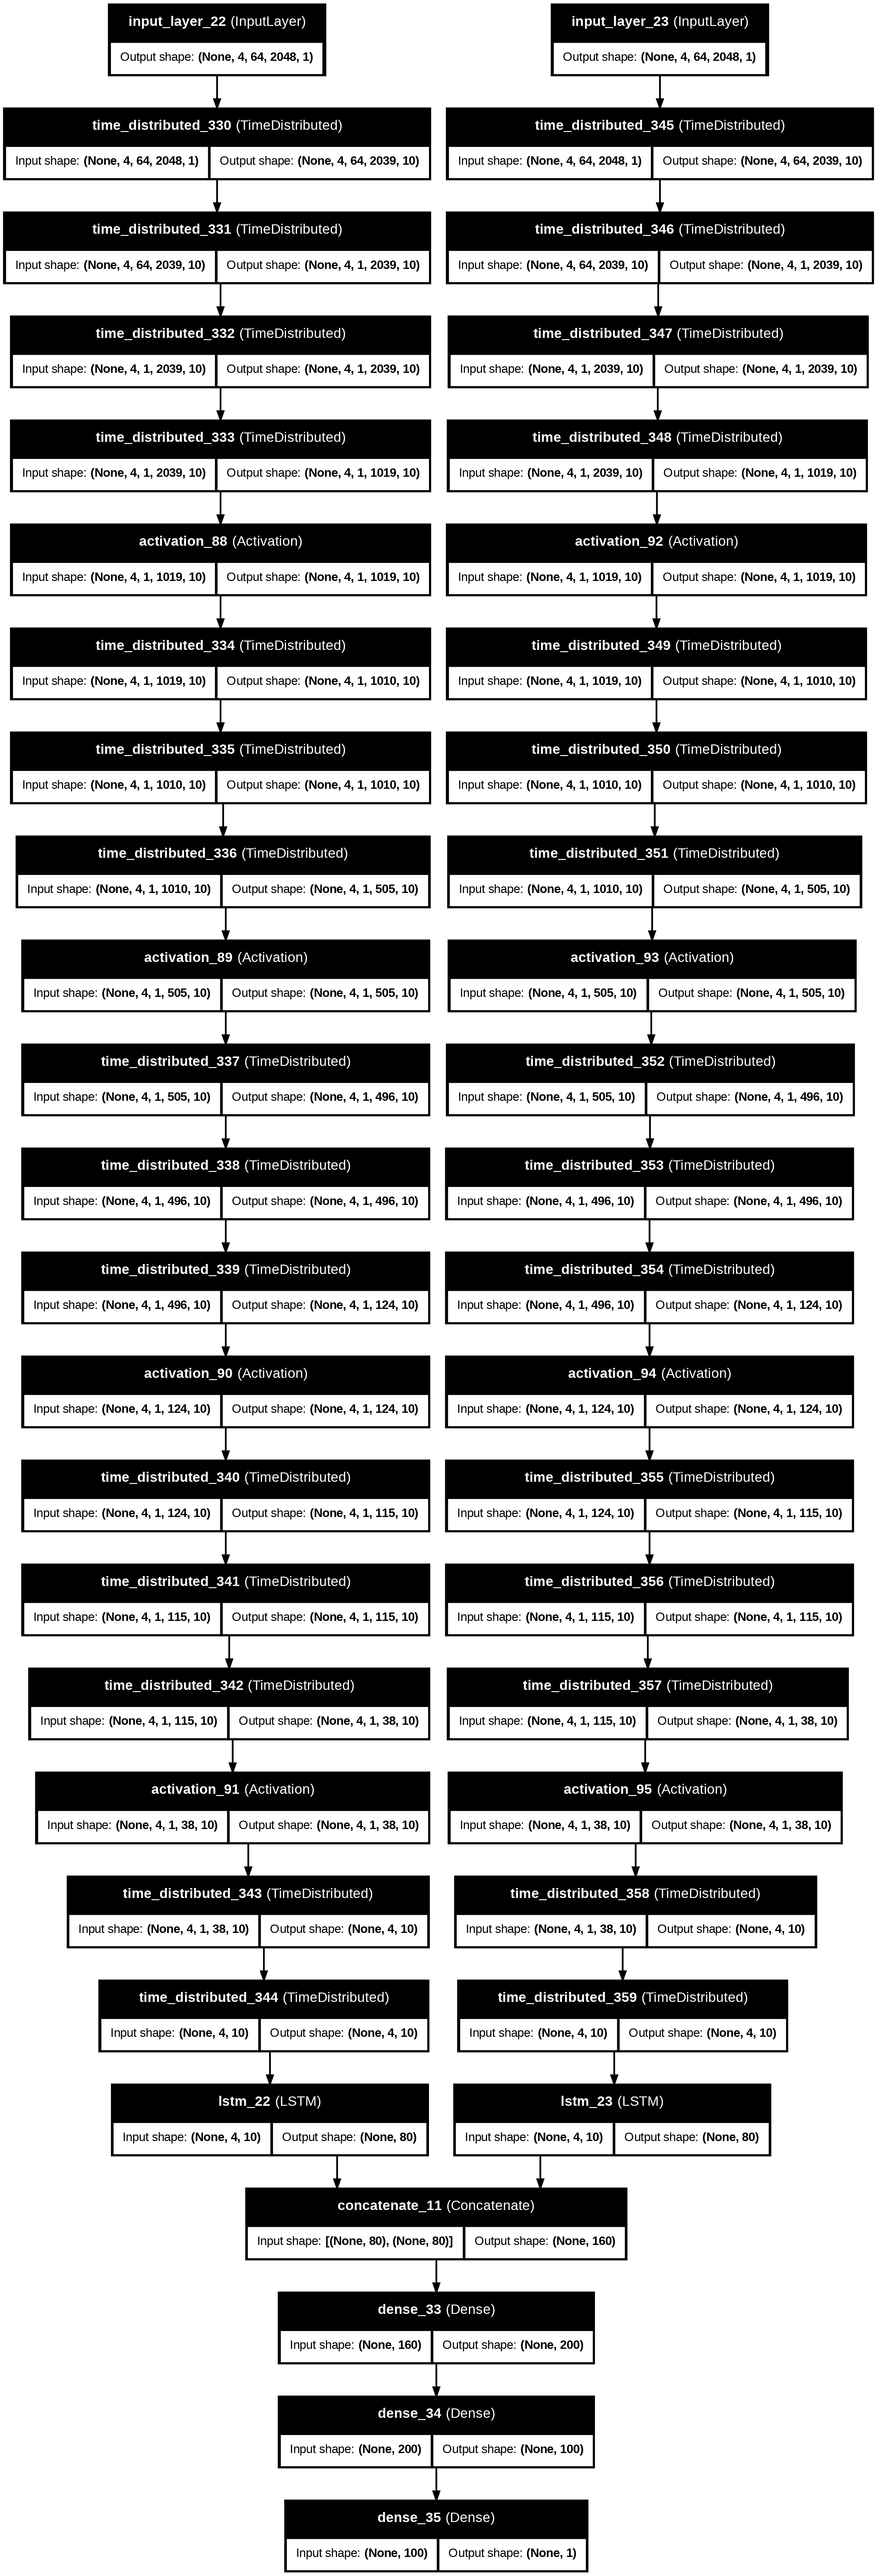

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_schematic.png', show_shapes=True, show_layer_names=True)
